# Homework 2: Multiple Layer Perceptron

# 1. Performance vs. Width

In this exercise, we will experiment with the number of hidden units in a multilayer perceptron (MLP) with a single hidden layer. The number of hidden units is also referred to the width of the hidden layer.

Here are the details:
- The setup is identical to the demo/lab and you may reuse that code. Take the FashionMNIST dataset and randomly subsample 12% of its training set to work with. As a test set, we will use the full test set of FashionMNIST.
- Define a MLP with one hidden layer of width h = 16. Find the divergent learning rate η∗ for this model and use a fixed learning rate of η∗/2, as we discussed in class.
- Train the model for 120 passes over the data.
- Repeat this procedure for widths h = 8, 32, 128, 512 with the same learning rate η∗/2 as above (i.e., you do not need to find the divergent learning rate of each model for this exercise).


The deliverables for this exercise are:
1. Make 4 plots, one each for the train loss, train accuracy, test loss and test accuracy over the course of training (i.e., the metric on the y-axis and number of effective passes on the x-axis). Plot all 4 lines, one for each value of h on the same plot.
2. When the training accuracy is 100%, the model is said to interpolate the training data. What is the smallest width at which we observe perfect interpolation of the training data?
3. As we vary the width of the network, at which training epoch do we observe perfect interpolation of the data? That is, make a plot with h on the x-axis and number of passes over the data required for interpolation on the y axis.

In [1]:
import numpy as np
import pandas as pd
import torch
from torchvision.datasets import FashionMNIST
from torch.nn.functional import cross_entropy
import time

import matplotlib.pyplot as plt 
%matplotlib inline 

# Fix the random seeds for reproducibility
torch.manual_seed(0)
np.random.seed(1)

### 1.1 Loading the MNIST dataset

We load the MNIST dataset and set up some helper functions to preprocess the data

In [2]:
# download dataset (~117M in size)
train_dataset = FashionMNIST('../../data', train=True, download=False)
X_train = train_dataset.data # torch tensor of type uint8 of shape (n, 28, 28)
y_train = train_dataset.targets.long() # torch tensor of type Long of shape (n,)
test_dataset = FashionMNIST('../../data', train=False, download=False)
X_test = test_dataset.data
y_test = test_dataset.targets.long()

# choose a subsample of 10% of the data:
idxs_train = torch.from_numpy(
    np.random.choice(X_train.shape[0], replace=False, size=int(X_train.shape[0]*0.12)))
X_train, y_train = X_train[idxs_train], y_train[idxs_train]
idxs_test = torch.from_numpy(
    np.random.choice(X_test.shape[0], replace=False, size=X_test.shape[0]))
X_test, y_test = X_test[idxs_test], y_test[idxs_test]

print(f'X_train.shape = {X_train.shape}')
print(f'n_train: {X_train.shape[0]}, n_test: {X_test.shape[0]}')
print(f'Image size: {X_train.shape[1:]}')

X_train.shape = torch.Size([7200, 28, 28])
n_train: 7200, n_test: 10000
Image size: torch.Size([28, 28])


One Row of Pixels: tensor([ 0,  0,  0,  0,  0,  0,  0,  1,  1,  0,  0,  0, 69, 98,  0, 95, 37,  0,
         0,  1,  1,  0,  0,  0,  0,  0,  0,  0], dtype=torch.uint8)


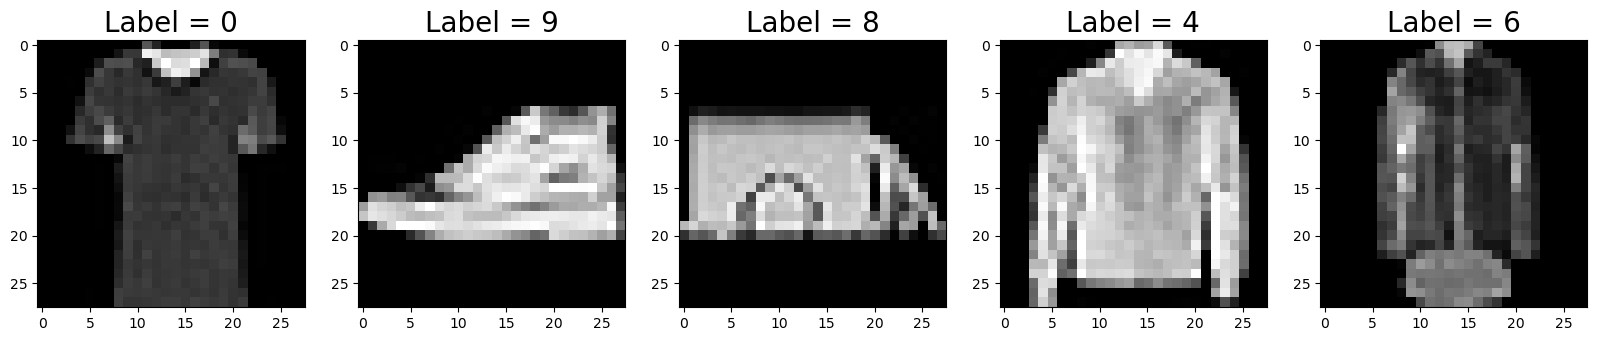

In [3]:
f, ax = plt.subplots(1, 5, figsize=(20, 4))
for i, idx in enumerate(np.random.choice(X_train.shape[0], 5)):
    ax[i].imshow(X_train[idx], cmap='gray', vmin=0, vmax=255)
    ax[i].set_title(f'Label = {y_train[idx]}', fontsize=20)
# Each number represents the grayscale intensity [0, 255]
print("One Row of Pixels:", X_train[0][0])

Let us normalize the data and define some utility functions. We start by flattening the $28 \times 28$ image into a vector of size $784$.

In [4]:
print("Original Shape:", X_train.shape)
X_train = X_train.float()  # convert to float32. Shape: (n, 28, 28)
X_train = X_train.view(-1, 784)  # Shape: (n, 784)
print("Flatten Shape:", X_train.shape)
mean, std = X_train.mean(axis=0), X_train.std(axis=0)  # Shape: (784,)

Original Shape: torch.Size([7200, 28, 28])
Flatten Shape: torch.Size([7200, 784])


In [5]:
# Normalize dataset: pixel values lie between 0 and 255
# Normalize them so the pixelwise mean is zero and standard deviation is 1
# Normalize: add a small number to avoid divide by zero
X_train = (X_train - mean[None, :]) / (std[None, :] + 1e-6) # Shape: (n, 784)

X_test = X_test.float()  # Shape: (n', 28, 28)
X_test = X_test.view(-1, 784)  # Shape: (n', 784)
X_test = (X_test - mean[None, :]) / (std[None, :] + 1e-6)  # Shape: (n', 784)

n_class = np.unique(y_train).shape[0]  # We have K=10 classes numbered (0, 1, ..., 9)
print("Number of Classes: ", n_class)


Number of Classes:  10


### 1.2 Setup Code for Multilayer Perceptron

In [6]:
# Some utility functions to compute the objective and the accuracy

def mlp(X, ws, bs):
    hidden = X # Shape: (n, d_0)
    for w, b in zip(ws[:-1], bs[:-1]):
        # hidden = relu(W_(r<j)x + b_(r<j))
        hidden = torch.matmul(hidden, w) + b[None, :]  # Shape: (n, d_{j-1}) * (d_{j-1}, d_j) = (n, d_j)
        hidden = torch.nn.functional.relu(hidden)
    # return W_j(hidden)+ b_j
    return torch.matmul(hidden, ws[-1]) + bs[-1][None, :]

def compute_objective(ws, bs, X, y, reg_param):
    """ Compute the multinomial logistic loss. 
        ws is a list of tensors of consistent shapes,
        X of shape (n, d) and y of shape (n,)
    """
    score = mlp(X, ws, bs)  # Shape: (n, K)
    # PyTorch's function cross_entropy computes the multinomial logistic loss
    # Adding L2 penalization
    return (
        cross_entropy(input=score, target=y, reduction='mean') 
        + 0.5 * reg_param * sum([torch.norm(w)**2 for w in ws])
    )

@torch.no_grad()
def compute_accuracy(ws, bs, X, y):
    """ Compute the classification accuracy
        ws is a list of tensors of consistent shapes 
        X of shape (n, d) and y of shape (n,)
    """
    score = mlp(X, ws, bs)  # shape: (n, K`)
    predictions = torch.argmax(score, axis=1)  # class with highest score is predicted
    return (predictions == y).sum() * 1.0 / y.shape[0]

@torch.no_grad()
def compute_logs(ws, bs, reg_param, verbose=False):
    train_loss = compute_objective(ws, bs, X_train, y_train, reg_param)
    test_loss = compute_objective(ws, bs, X_test, y_test, reg_param)
    train_accuracy = compute_accuracy(ws, bs, X_train, y_train)
    test_accuracy = compute_accuracy(ws, bs, X_test, y_test)
    if verbose:
        print(('Train Loss = {:.3f}, Train Accuracy = {:.3f}, ' + 
               'Test Loss = {:.3f}, Test Accuracy = {:.3f}').format(
                train_loss.item(), train_accuracy.item(), 
                test_loss.item(), test_accuracy.item())
    )
    return (train_loss, train_accuracy, test_loss, test_accuracy)

Let us again write the analogous function to make a pass of SGD.

In [7]:
def sgd_one_pass(ws, bs, X, y, reg_param, learning_rate, verbose=False):
    num_examples = X.shape[0]
    average_loss = 0.0
    for i in range(num_examples):
        idx = np.random.choice(X.shape[0])
        # compute the objective. 
        # Note: This function requires X to be of shape (n,d). In this case, n=1 
        objective = compute_objective(ws, bs, X[idx:idx+1], y[idx:idx+1], reg_param)
  
        average_loss = 0.99 * average_loss + 0.01 * objective.item()
        if verbose and (i+1) % 100 == 0:
            print(average_loss)
        
        # compute the gradient using automatic differentiation
        all_parameters = [*ws, *bs]
        gradients = torch.autograd.grad(outputs=objective, inputs=all_parameters)
        
        # perform SGD update. IMPORTANT: Make the update inplace!
        with torch.no_grad():
            for (var, g) in zip(all_parameters, gradients):
                var -= learning_rate * g
    return ws, bs

### 1.3 Finding divergent learning rate

As we change the learning rate, there are two extreme regimes:

- If the learning rate is too large, the weights diverge to infinity (that is, the coordinates of $w$ increase without bound to $\pm\infty$).
- On the other hand, if the learning rate is too small, the optimization takes a very large number of iterations to converge (the per iteration cost is quite high for complex model). 

In order to balance these two, we look for the *divergent learning rate*. We say $\eta^\star$ is the divergent learning rate if SGD with a learning rate of $2\eta^\star$ diverges, but SGD with a learning rate of $\eta^\star$ does not. 

**Divergent LR Heuristic**: A good starting learning rate is $\eta^\star/2$. 

Find the divergent learning rate. Edit the code below to change the learning rate. 

*Hint 1*: Try different orders of magnitude. For instance, start with 1e-2. If it diverges, try 1e-6, if not, try 10.0. Once we establish a lower and upper bound on it, finding the divergent learning rate comes down to a binary search (on a logarithmic scale). 

*Hint 2*: A common strategy is to search in powers of 10 (as in hint 1), and then narrow the search down in powers of 2. For instance, if we end up with 1e-3 as an estimate of the divergent learning from hint 1, try out 2e-3 and 4e-3 as well in order to refine the estimate of the divergent learning rate. 

**Note**: the divergent learning rate is a heuristic which gives the right ballpark figure of the learning rate. 
A learning rate that satisfies the heuristic might still result in the loss diverging, in which case we would have redo the process with half that learning rate.

In [8]:
torch.manual_seed(0)
np.random.seed(1)
reg_param = 0.0

learning_rate = 1e-2

hidden_size = 16 # Specifying hidden layer size as required by the assignment
ws = [1e-6 * torch.randn(784, hidden_size, requires_grad=True),
      1e-6 * torch.randn(hidden_size, n_class, requires_grad=True)]
bs = [torch.zeros(hidden_size, requires_grad=True),
      torch.zeros(n_class, requires_grad=True)]

_ = compute_logs(ws, bs, reg_param, verbose=True)


ws, bs = sgd_one_pass(ws, bs, X_train, y_train, reg_param, learning_rate, verbose=True)
_ = compute_logs(ws, bs, reg_param, verbose=True)


Train Loss = 2.303, Train Accuracy = 0.083, Test Loss = 2.303, Test Accuracy = 0.081
1.4602855443442406
1.9914672689465307
2.190249587064884
2.2543304791256853
2.2815595363116805
2.268722927783318
2.0477432164231826
1.8871491136353395
1.7258144618411517
1.4211583909763912
1.3216764810278707
1.1953618297129833
1.1780433892492583
1.2165141571048008
1.2429606947069363
1.0701868445613216
0.9928330581930458
1.0052379314686888
0.9065293018627636
0.9522599300567698
0.9371706918958739
0.8844464047107415
0.8186165748104676
0.8131910642676007
0.8910933124048723
0.8200543628503526
0.9334232478382668
0.7642089777075686
0.650189653181696
0.6489457886698646
0.7759334043294583
0.7804062333521101
0.9015311581392766
0.8129594256155092
0.8368987538751619
0.6919538223494238
0.7223510477588927
0.6676960985486641
0.6605225315076836
0.7412658207629533
0.8203499294539082
0.7624322808985978
0.7810924214862878
0.6893410518388317
0.6973349653142915
0.6238743659006077
0.6435956339308255
0.633609955069441
0.80020

In [9]:
# We find that 1e-2 is a good candidate for the divergent learning rate. We show this by running the code with 2*1e-2

torch.manual_seed(0)
np.random.seed(1)
reg_param = 0.0

learning_rate = 2e-2

hidden_size = 16 # Specifying hidden layer size as required by the assignment
ws = [1e-6 * torch.randn(784, hidden_size, requires_grad=True),
      1e-6 * torch.randn(hidden_size, n_class, requires_grad=True)]
bs = [torch.zeros(hidden_size, requires_grad=True),
      torch.zeros(n_class, requires_grad=True)]

_ = compute_logs(ws, bs, reg_param, verbose=True)


ws, bs = sgd_one_pass(ws, bs, X_train, y_train, reg_param, learning_rate, verbose=True)
_ = compute_logs(ws, bs, reg_param, verbose=True)

Train Loss = 2.303, Train Accuracy = 0.083, Test Loss = 2.303, Test Accuracy = 0.081
1.46107600713891
1.9903788106504632
2.1612076340990174
1.9793689601488735
1.7811635875949923
1.5341314154628456
1.4288282150399647
1.412291846771766
1.4106128901755381
1.1217416641903128
1.2703717094377363
1.1799129702774596
1.3621871539763537
1.6740801074301304
1.4542208034664188
1.1532732592158481
1.0485062337958628
1.2559974061789503
1.2824544304436545
1.3945337291726343
1.4107607037666101
1.3300449729007322
0.9975905290909645
0.8951120629321635
1.0454754343215547
1.1647457756272408
1.4036739032697207
1.0555314466596313
1.1789548197238717
0.9281729026506668
1.3315724068343913
1.5850403038775536
1.9947450036530174
1.8620281309683102
1.7296919596206553
1.4583310664808136
1.3468045906955213
1.2060831757322303
1.4546425622405261
1.5589335158620128
1.7397043393621117
1.7013752774986235
3.0924652363484966
2.476016932195362
2.1601350411275555
2.4111813762807186
2.339921457806841
2.102219867115858
2.4719179

We see that the loss diverges with 2e-2. So 1e-2 is a good candidate for the divergent learning rate ($\eta^\star$). We will use 5e-3 as the learning rate ($\eta^\star/2$)

### 1.4 Train the model for 120 passes over the training data for h=16

In [12]:
divergent_learning_rate = 5e-3

def train_model(learning_rate=divergent_learning_rate, hidden_size=16):

      logs = []

      ws = [1e-6 * torch.randn(784, hidden_size, requires_grad=True),
            1e-6 * torch.randn(hidden_size, n_class, requires_grad=True)]
      bs = [torch.zeros(hidden_size, requires_grad=True),
            torch.zeros(n_class, requires_grad=True)]
      logs.append(compute_logs(ws, bs, reg_param, verbose=True))

      for j in range(120):
            ws, bs = sgd_one_pass(ws, bs, X_train, y_train, reg_param, learning_rate, verbose=False)
            logs.append(compute_logs(ws, bs, reg_param, verbose=False))

      logs = np.asarray(logs)
      logs = np.hstack((np.ones((logs.shape[0], 1))*hidden_size, logs))

      return logs


In [13]:
df_cols = ['hidden_size', 'train_loss', 'train_accuracy', 'test_loss', 'test_accuracy']
results_16 = pd.DataFrame(columns=df_cols, data=train_model())

Train Loss = 2.303, Train Accuracy = 0.113, Test Loss = 2.303, Test Accuracy = 0.110


### 1.5 Repeat for different values of hidden layer size

#### 1.5.1 h=8

In [14]:
results_8 = pd.DataFrame(columns=df_cols, data=train_model(hidden_size=8))

Train Loss = 2.303, Train Accuracy = 0.143, Test Loss = 2.303, Test Accuracy = 0.144


#### 1.5.2 h=32

In [15]:
results_32  = pd.DataFrame(columns=df_cols, data=train_model(hidden_size=32))

Train Loss = 2.303, Train Accuracy = 0.114, Test Loss = 2.303, Test Accuracy = 0.112


#### 1.5.3 h=128

In [16]:
results_128 = pd.DataFrame(columns=df_cols, data=train_model(hidden_size=128))

Train Loss = 2.303, Train Accuracy = 0.137, Test Loss = 2.303, Test Accuracy = 0.135


#### 1.5.4 h=512

In [17]:
results_512 = pd.DataFrame(columns=df_cols, data=train_model(hidden_size=512))

Train Loss = 2.303, Train Accuracy = 0.079, Test Loss = 2.303, Test Accuracy = 0.071


### 1.6 Assignment Deliverables

In [18]:
# Appending results to a single dataframe
results = pd.concat([results_16, results_8, results_32, results_128, results_512], axis=0)

In [19]:
# Find first occurernce of train_accuracy = 1.0 for each hidden size
results['iter'] = results.index+1

In [20]:
# Write to csv
results.to_csv('results.csv', index=False)

#### 1.6.1 Make 4 plots, one each for the train loss, train accuracy, test loss and test accuracy over the course of training (i.e., the metric on the y-axis and number of effective passes on the x-axis). Plot all 4 lines, one for each value of h on the same plot.

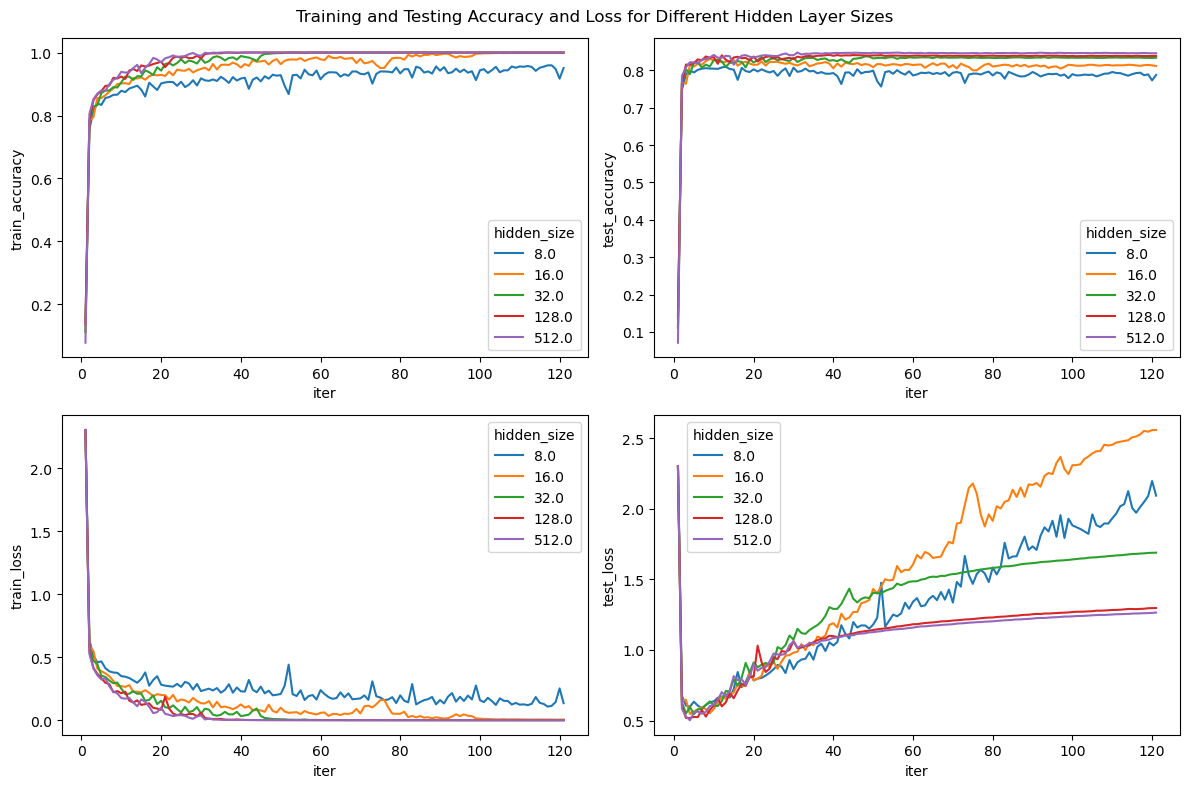

In [91]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2,2)
fig.set_size_inches(12, 8)

fig.suptitle('Training and Testing Accuracy and Loss for Different Hidden Layer Sizes')
sns.lineplot(x='iter', y='train_accuracy', hue='hidden_size', data=results, ax=ax[0,0], palette='tab10')
sns.lineplot(x='iter', y='test_accuracy', hue='hidden_size', data=results, ax=ax[0,1], palette='tab10')
sns.lineplot(x='iter', y='train_loss', hue='hidden_size', data=results, ax=ax[1,0], palette='tab10')
sns.lineplot(x='iter', y='test_loss', hue='hidden_size', data=results, ax=ax[1,1], palette='tab10')
# shift legend to the right
ax[1,1].legend(title='hidden_size', loc='upper left', bbox_to_anchor=(0.05,1))
fig.tight_layout()

#### 1.6.2. When the training accuracy is 100%, the model is said to interpolate the training data. What is the smallest width at which we observe perfect interpolation of the training data?

In [37]:
interpolation_data = results.where(results['train_accuracy'] == 1.0).dropna().sort_values(by=['hidden_size','iter']).groupby('hidden_size').first().reset_index()
print(f'Smallest width of the hidden layer for which the training accuracy reaches 100%: {interpolation_data["hidden_size"].min()}')

Smallest width of the hidden layer for which the training accuracy reaches 100%: 128.0


#### 1.6.3. As we vary the width of the network, at which training epoch do we observe perfect interpolation of the data? That is, make a plot with h on the x-axis and number of passes over the data required for interpolation on the y axis.

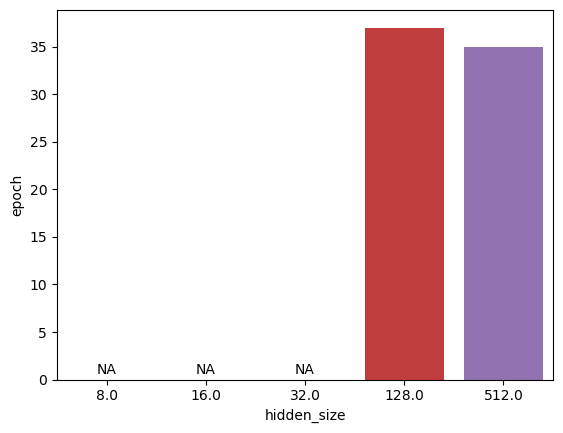

In [62]:
widths = results[['hidden_size']].groupby('hidden_size').count().reset_index()
epoch_results = widths.merge(interpolation_data, on='hidden_size', how='left')
epoch_results = epoch_results.rename(columns={'iter': 'epoch'})

sns.barplot(x='hidden_size', y='epoch', data=epoch_results, palette='tab10')
for y in [0, 1, 2]:
    plt.annotate('NA', xy=(y,1), xytext=(y, 1),fontsize=10, ha='center', va='center')